# Global Warming

Study made in October 2019.

Are we really on a globa

First, we have to define some utility routines:

In [1]:
# Needed Julia packages:
#   DelimitedFiles: for readdlm() needed for importing data
#   Statistics: for mean()
#   FFTW: for fft()
#   DSP: for fftfreq()
#   Plots: for drawing data with plot()
using DelimitedFiles, Statistics, FFTW, DSP, Plots;

In [2]:
# Percent error between an exact and an approximate value
percent_error(approx, exact) = 100.0 * abs(approx - exact) / exact

percent_error (generic function with 1 method)

In [3]:
# Find the first max value and its index from a given array.
# Note: Quick & dirty algorithm: the array need to be filtered
# and we suppose a maximum is found within the range [s:e].
function findOptimum(A::Array{Float64}, s::Int64, e::Int64)
    i = s
    while (i < e) && (A[i] < A[i + 1]) 
        i = i + 1
    end
    return i, A[i]
end

findOptimum (generic function with 1 method)

In [4]:
# Linear regression
linreg(x, y) = hcat(fill!(similar(x), 1), x) \ y

# Constrain x between low and high
constrain(x, low, high) = (x < low) ? low : (x > high ? high : x)

# Convert a year to array index and constrain it inside the array range
y2i(A::Array, y::Int64) = 1 + y - Int64(A[1])
# constrain(1 + y - Int64(A[1]), 1, length(A))

y2i (generic function with 1 method)

In [5]:
# Filter function based on FFT
# r: range of frequencies we want to preserve:
#   preserve low +ve frequencies [1:r+1]
#   preserve low -ve frequencies [end-r+1:end]
# Unpreserved frequencies are zero'ed.
function filtFFT(S::Vector{Float64}, r::Int64)
    F = fft(S)
    F[r+1:end-r+1] .= 0.0
    real(ifft(F))
end

filtFFT (generic function with 1 method)

In [6]:
function border2line(X::Vector{Int64}, Y::Vector{Float64}, step::Int64=1)
    y0 = Y[1]
    
    dy = Y[end] - Y[1]
    dx = Float64(X[end] - X[1])
    m = step * dy / dx
    
    l=length(Y)
    R=ones(l)
    for n = 1:l
        y0 += m
        R[n] = y0
    end
    R
end

border2line (generic function with 2 methods)

## HadCRUT4's temperature anomalies

In [7]:
# HadCRUT4: matrix year-month of temperature anomalies since 1850
#  1st column = year
#  other colum = 12 temperature (one by month)
H = convert(Matrix{Float64}, readdlm("data/HadCRUT4.txt", ' ', Any, '\n'))

# Dh: years, Th: averaged temperature over each year. h: HadCRUT4
Dh, Th = convert(Vector{Int64}, H[:,1]), mean(H[:,2:end]; dims=2)[:]

# Convert HadCRUT4 year to HadCRUT4 index
yh2i(y::Int64) = y2i(Dh, y)

yh2i (generic function with 1 method)

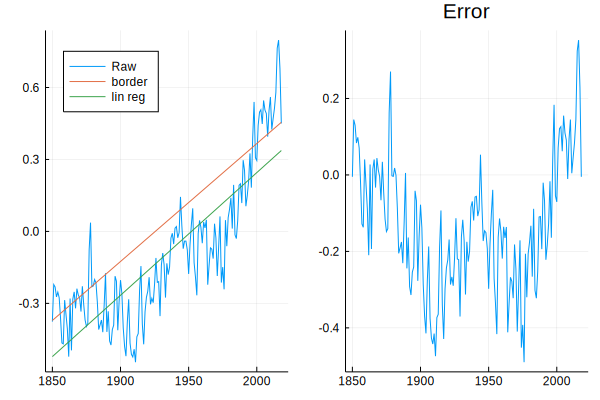

In [8]:
# Get the linear regression of temperatures over years
b, a = linreg(Dh, Th)
regression = a .* Dh .+ b

regTh = border2line(Dh, Th)

plot(plot(Dh, [Th regTh regression], 
         label=["Raw" "border" "lin reg"], legend=:topleft),
     plot(Dh, Th .- regTh, title="Error", leg=false),
     layout=2)

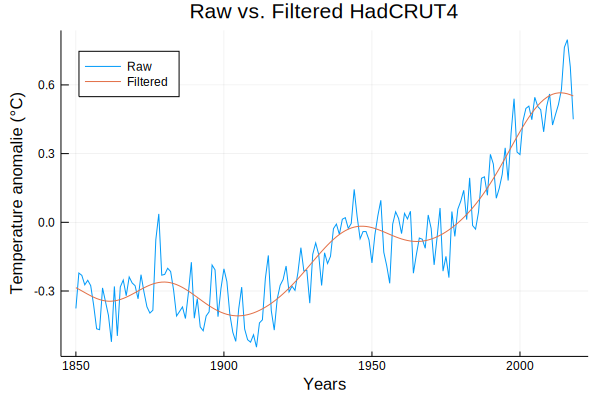

In [9]:
# Filter the raw signal minus its linear regression. Thf: HadCRUT4 filtered temperature.
Thf = filtFFT(Th .- regTh, 6) .+ regTh

plot(Dh, [Th Thf], title = "Raw vs. Filtered HadCRUT4",
                   xlabel="Years", ylabel="Temperature anomalie (°C)", 
                   label=["Raw" "Filtered"], legend=:topleft)

Note the peak at 2015 -- 2016 implied by El Niño.

## My personal model

My personal model is only based on filtered HadCRUT4 values. We notice 3 cycles where the temperature is optimum since year 1850:
- 1st cycle at around year 1880
- 2nd cycle at around year 1950
- 3th cycle at around year 2016

In [10]:
i1, Tc1 = findOptimum(Thf, yh2i(1870), yh2i(1890))
i2, Tc2 = findOptimum(Thf, yh2i(1940), yh2i(1955))
i3, Tc3 = findOptimum(Thf, yh2i(2000), yh2i(Dh[end]))
y1, y2, y3 = Dh[i1], Dh[i2], Dh[i3]

[y1 y2 y3], [Tc1 Tc2 Tc3]

([1880 1947 2014], [-0.260844 -0.017019 0.565471])

These cycles seem to be periodic:

In [11]:
y2 - y1, y3 - y2, "years"

(67, 67, "years")

Estimated next optimum cycle:

In [12]:
y4 = y3 + (y2 - y1 + y3 - y2) ÷ 2

2081

Let suppose a new cycle will apear on years ~2090 and where the ratio of the amplitude between the third cycle (year 2016) and the second cycle (year 1950) is the same than the second cycle and the first (year 1880). This supposition comes from the worst scenario:
- the human kind economy and energy will keep increasing with the same current **exponential** rate:
  - 1850: 1.4 billion humans World energy consumption: 20 exajoules.
  - 1950: 2.5 billion humans. World energy consumption: 100 exajoules.
  - 2019: 7.5 billion. World energy consumption: 500 exajoules.
  - 2100: >15 billion. World energy consumption: >1000 exajoules.
- the temperature raise is mainly due by the human kind;

We can estimate the temperature (°C) for ~2090:

In [13]:
Tc32 = Tc3 - Tc2                # Delta temperature between third cycle and second cycle
Tc21 = Tc2 - Tc1                # Delta temperature between second cycle and first cycle
EstimTh = Tc32 * (Tc32 / Tc21)  # Estimated temperature (exponential rate)

1.3915477148652418

## GIEC's AR5 Model

In [14]:
G = convert(Matrix{Float64}, readdlm("data/AR5.txt", ' ', Any, '\n'));

# We halt the GIEC's model to Year 2020 because after the model is purely linear
Dend = Int64(2020 - G[1,1])

# D: years, T: temperature. g: GIEC
Dg, Tg = convert(Vector{Int64}, G[1:Dend,1]), G[1:Dend,2]

# Convert GIEC year to GIEC index
yg2i(y::Int64) = y2i(G[:,1], y)

# Offset between GIEC value and HadCRUT4
# we mean on years [1980:2010] because AR5 was made on 2013.
Toff = mean(Th[yh2i(1980):yh2i(2010)]) - mean(Tg[yg2i(1980):yg2i(2010)])
Tg = Tg .+ Toff;

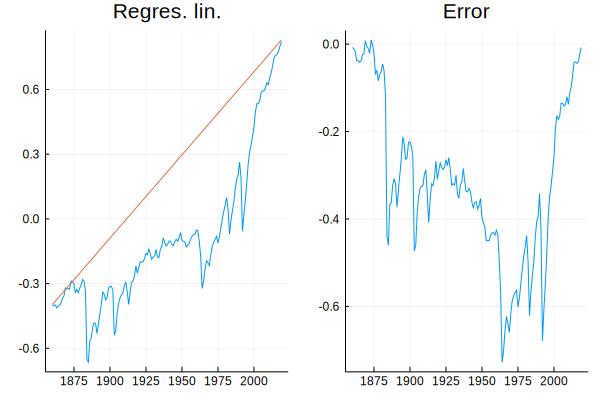

In [15]:
# Get the linear regression of GIEC temperature model over years
#b, a = linreg(Dg, Tg)
#regTg = a .* Dg .+ b
regTg = border2line(Dg, Tg)

plot(plot(Dg, [Tg regTg], title="Regres. lin.", leg=false),
     plot(Dg, Tg .- regTg, title="Error", leg=false),
     layout=2)

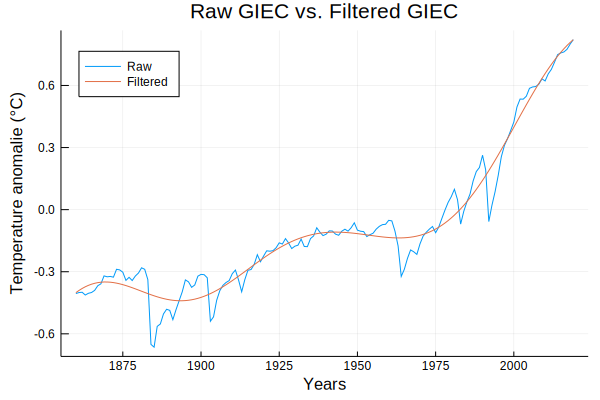

In [16]:
# Filtered GIEC model
Tgf = filtFFT(Tg .- regTg, 4) .+ regTg

plot(Dg, Tg, title="Raw GIEC vs. Filtered GIEC",
             xlabel="Years", ylabel="Temperature anomalie (°C)", 
             label="Raw", legend=:topleft)
plot!(Dg, Tgf, label="Filtered")

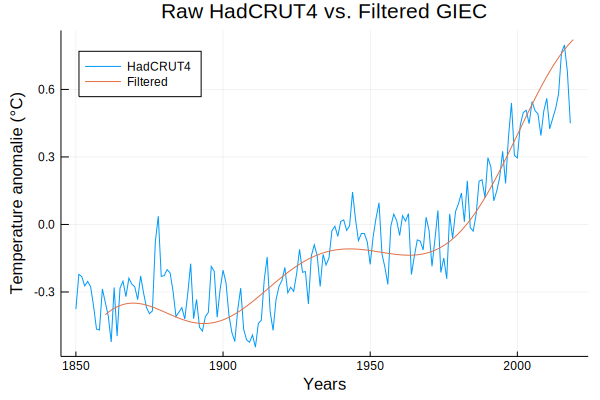

In [17]:
plot(Dh, Th, title="Raw HadCRUT4 vs. Filtered GIEC",
             xlabel="Years", ylabel="Temperature anomalie (°C)", 
             label="HadCRUT4", legend=:topleft)
plot!(Dg, Tgf, label="Filtered")

GIEC model seems to look good because the filtered curved crosses the El Niño in 2016 but the AR5 model was made in 2013 and medium temperatures after 2000 are not well modelized as visualized in the next figure.

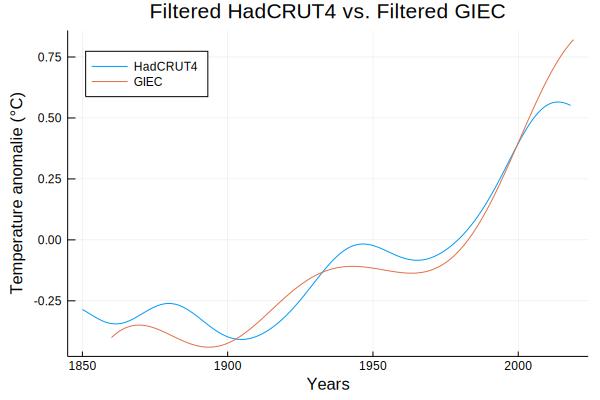

In [18]:
# Filtered GIEC model versus filtered HadCRUT4
plot(Dh, Thf, title="Filtered HadCRUT4 vs. Filtered GIEC",
              xlabel="Years", ylabel="Temperature anomalie (°C)", 
              label="HadCRUT4", legend=:topleft)

plot!(Dg, Tgf, label="GIEC")

## Error of GIEC model

The GIEC model is not good at all! The slope of their model since years 1980 is linear and did not predict the optimum seen in filtered HadCRUT4 in years 2016. In addition their model did not stick to observation in previous years. Our model is based on worst scenario (the human kind economy and energy will keep increasing with the same current exponential rate), while GIEC based on global population around 7 billions, and we found that the predicted temperature will be only around +1.6°C.

Precent error compared to current filtered real temperature at the third cycle (around year 2016):

In [19]:
y3, percent_error(Tgf[yg2i(y3)], Thf[yh2i(y3)])

(2014, 31.16944731983479)

Estimated Temperature (°C) for the next optimum cycle:

In [20]:
Y, EstimTg = y4, G[yg2i(y4),2] - Toff

(2081, 1.213683875186104)

GIEC model error compared to temperature HadCRUT4 based model:

In [21]:
percent_error(EstimTg, EstimTh)

12.781727696370229

## Ljungqvist's Temperature Reconstruction

In [22]:
# Ljungqvist dataset:
#   1st column: temporal slice (ie 09 means from year to year 9).
#   2nd column: averaged temperature over 10 years (from year 0 to 2000).
L = convert(Matrix{Float64}, readdlm("data/ljung.txt", ' ', Any, '\n'));
Dl = convert(Vector{Int64}, [1:size(L,1);]) .* 10
Tl = L[:,2];

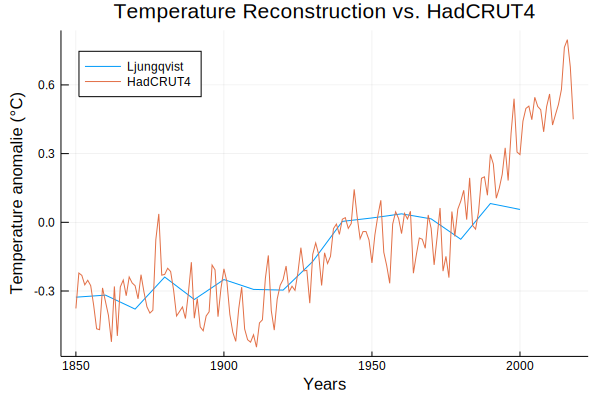

In [23]:
plot(Dl[185:end], Tl[185:end],
    title="Temperature Reconstruction vs. HadCRUT4",
    xlabel="Years", ylabel="Temperature anomalie (°C)", 
    label="Ljungqvist", legend=:topleft)

plot!(Dh, Th, label="HadCRUT4")

Complete Ljungqvist missing temperatures (year 2000 -- 2019) with HadCRUT4 values.

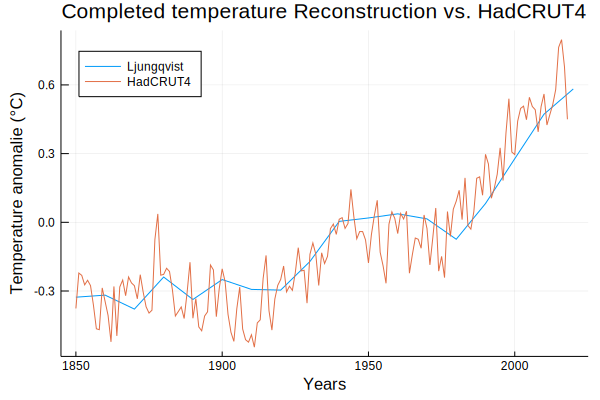

In [24]:
# Recompute the temperature on decade 1990--2000 because it looks wrong
Tl[end] = mean(Th[yh2i(1990):yh2i(2000)])

# Complete data with the two last decades
Dl = [Dl; 2010; 2020]
Tl = [Tl; mean(Th[yh2i(2000):yh2i(2010)]);
          mean(Th[yh2i(2010):yh2i(Dh[end])])]

plot(Dl[185:end], Tl[185:end],
    title="Completed temperature Reconstruction vs. HadCRUT4",
    xlabel="Years", ylabel="Temperature anomalie (°C)", 
    label="Ljungqvist", legend=:topleft)

plot!(Dh, Th, label="HadCRUT4")

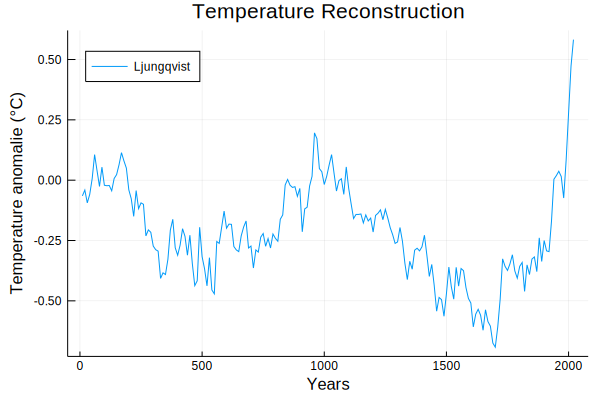

In [25]:
plot(Dl, Tl, title="Temperature Reconstruction", xlabel="Years", ylabel="Temperature anomalie (°C)", 
             label="Ljungqvist", legend=:topleft)

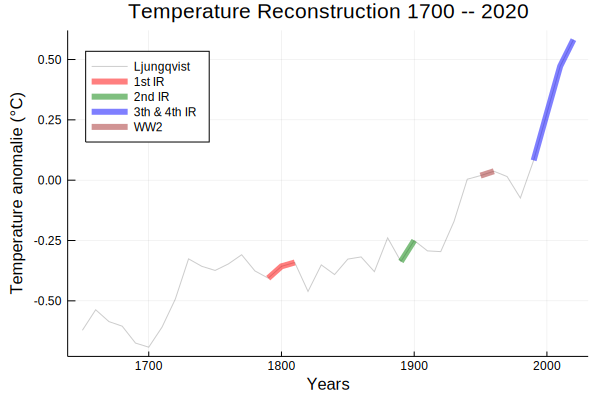

In [26]:
plot(Dl[165:end], Tl[165:end], 
    title="Temperature Reconstruction 1700 -- 2020", 
    xlabel="Years", ylabel="Temperature anomalie (°C)", line=(:black, 0.2, 1, :solid), 
    label="Ljungqvist", legend=:topleft)
plot!(Dl[179:181], Tl[179:181], line=(:red, 0.5, 6, :solid), label="1st IR")
plot!(Dl[189:190], Tl[189:190], line=(:green, 0.5, 6, :solid), label="2nd IR")
plot!(Dl[199:end], Tl[199:end], line=(:blue, 0.5, 6, :solid), label="3th & 4th IR")
plot!(Dl[195:196], Tl[195:196], line=(:brown, 0.5, 6, :solid), label="WW2")

No relation with Industrial Revolutions:
- First Industrial Revolution: 1780 -- 1810
- Second Industrial Revolution: 1880 -- 1900
- Third and fourth Industrial Revolution: > 1980

## Slopes of years 1700, 1920 and 2000

Same slope :

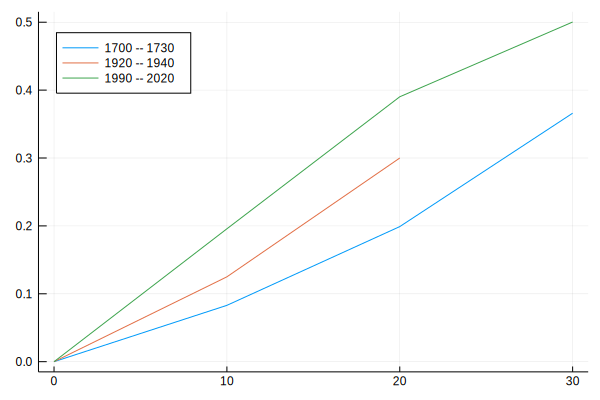

In [27]:
plot(Dl[170:173] .- 1700, Tl[170:173] .- Tl[170], label="1700 -- 1730", legend=:topleft)
plot!(Dl[192:194] .- 1920, Tl[192:194] .- Tl[192], label="1920 -- 1940")
plot!(Dl[199:end] .- 1990, Tl[199:end] .- Tl[199], label="1990 -- 2020")

### 1000-year cycle

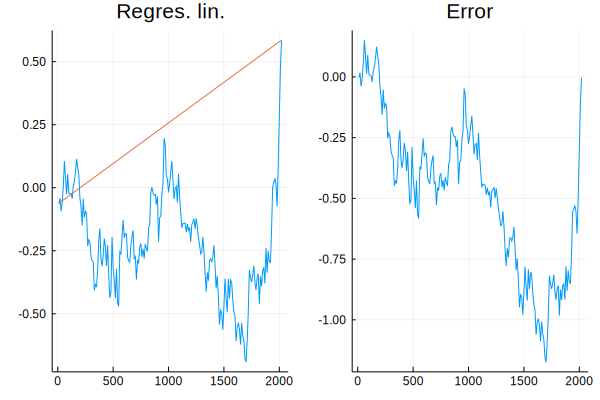

In [28]:
# Get the linear regression of Ljungqvist temperature model over years
#b, a = linreg(Dl, Tl)
#regTl = a .* Dl .+ b
regTl = border2line(Dl, Tl, 10)

plot(plot(Dl, [Tl regTl], title="Regres. lin.", leg=false),
     plot(Dl, Tl .- regTl, title="Error", leg=false),
     layout=2)

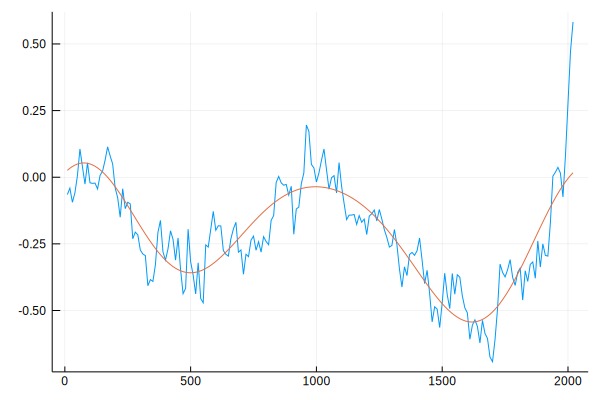

In [29]:
Tlf1000 = filtFFT(Tl, 4)
plot(Dl, [Tl Tlf1000], leg=false)

### 200-year cycle

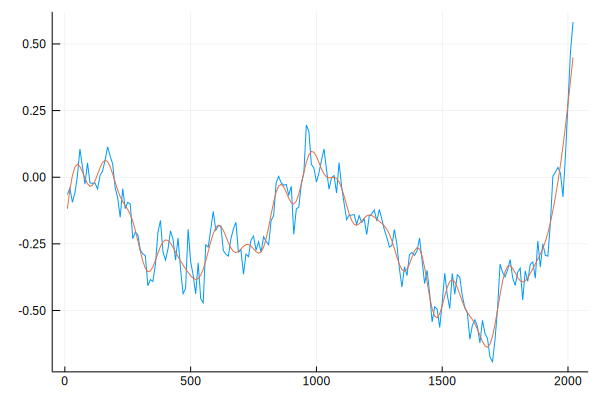

In [30]:
Tlf200 = filtFFT(Tl .- regTl, 20) .+ regTl
plot(Dl, [Tl Tlf200], leg=false)

### 60-year cycle

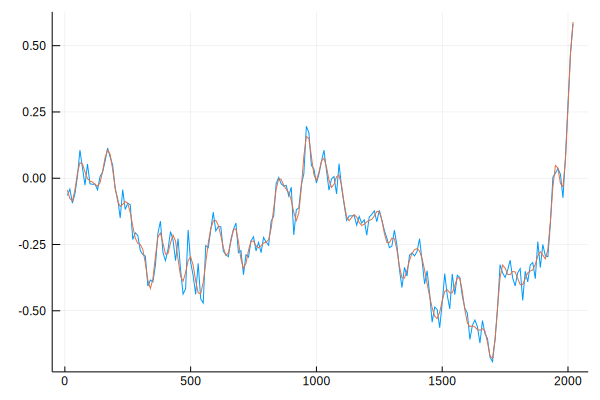

In [31]:
Tlf60 = filtFFT(Tl.- regTl, 40) .+ regTl
plot(Dl, [Tl Tlf60], leg=false)

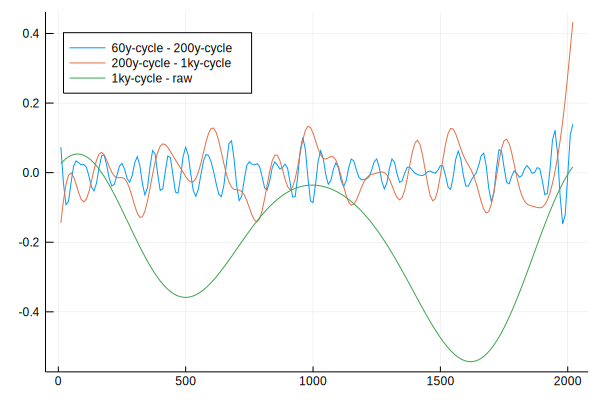

In [32]:
A = Tlf60 - Tlf200
B = Tlf200 - Tlf1000
C = Tlf1000

plot(Dl,  A, label="60y-cycle - 200y-cycle", legend=:topleft)
plot!(Dl, B, label="200y-cycle - 1ky-cycle")
plot!(Dl, C, label="1ky-cycle - raw")

## Are we on the max of 3 cycles?

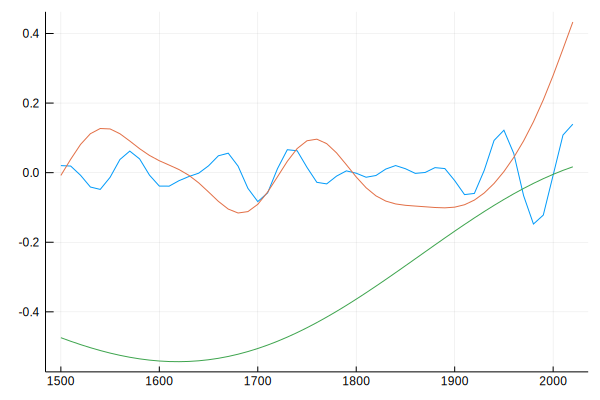

In [33]:
plot(Dl[150:end], A[150:end], leg=false)
plot!(Dl[150:end], B[150:end], leg=false)
plot!(Dl[150:end], C[150:end], leg=false)